# Milestone 2: Ridge Regression - The Analytical Anchor

This notebook benchmarks iterative optimizers (SGD) against the analytical closed-form solution of Ridge Regression.

## Objectives
1. **Controlled Ill-conditioning**: Generate data with specific condition numbers.
2. **Analytical Baseline**: Compute $w^* = (X^T X + n\\lambda I)^{-1} X^T y$.
3. **Convergence Analysis**: Track the optimality gap $\\|w_k - w^*\\|_2$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import json
import os
import yaml

# Ensure output directories exist
os.makedirs("figures", exist_ok=True)
os.makedirs("results", exist_ok=True)

def load_config(path):
    if os.path.exists(path):
        with open(path, 'r') as f:
            return yaml.safe_load(f)
    return {"n_samples": 500, "n_features": 20, "lambda": 0.1, "lr": 0.01, "iterations": 1000, "condition_number": 10.0}

config = load_config("configs/ridge.yaml")
print(f"Experiment Configuration: {config}")

Experiment Configuration: {'n_samples': 500, 'n_features': 20, 'lambda': 0.1, 'lr': 0.01, 'iterations': 1000, 'condition_number': 10.0}


## 1. Standalone Components

In [2]:
try:
    from src.utils import generate_synthetic_data, compute_ridge_closed_form
    from src.reproducibility import set_seed
    print("Successfully imported from src library.")
except ImportError:
    print("src/ not found. Defining core components locally for standalone execution.")

    def set_seed(seed=42):
        np.random.seed(seed)

    def generate_synthetic_data(n, d, condition_number=1.0):
        # Generate random matrix
        X = np.random.randn(n, d)
        U, S, Vt = np.linalg.svd(X, full_matrices=False)
        # Force specific condition number by modifying singular values
        S = np.linspace(condition_number, 1, len(S))
        X = U @ np.diag(S) @ Vt
        w_true = np.random.randn(d)
        y = X @ w_true + np.random.normal(0, 0.1, n)
        return X, y, w_true

    def compute_ridge_closed_form(X, y, lmbda):
        n, d = X.shape
        # Ridge Closed Form: w* = (X^T X + n*lambda*I)^-1 X^T y
        return np.linalg.solve(X.T @ X + n * lmbda * np.eye(d), X.T @ y)

set_seed(42)

src/ not found. Defining core components locally for standalone execution.


## 2. Generating Data & Closed Form Solution

In [3]:
X, y, w_true = generate_synthetic_data(
    config['n_samples'],
    config['n_features'],
    condition_number=config.get('condition_number', 10.0)
)
w_star = compute_ridge_closed_form(X, y, config['lambda'])
print(f"Closed-form solution computed for condition number {config.get('condition_number', 10.0)}.")

Closed-form solution computed for condition number 10.0.


## 3. Iterative Optimization (SGD)
We track the distance to $w^*$ at every step to verify convergence.

Iteration 0/1000 | Gap: 1.60e+00
Iteration 100/1000 | Gap: 1.28e+00
Iteration 200/1000 | Gap: 1.03e+00
Iteration 300/1000 | Gap: 8.28e-01
Iteration 400/1000 | Gap: 6.71e-01
Iteration 500/1000 | Gap: 5.47e-01
Iteration 600/1000 | Gap: 4.48e-01
Iteration 700/1000 | Gap: 3.68e-01
Iteration 800/1000 | Gap: 3.04e-01
Iteration 900/1000 | Gap: 2.52e-01


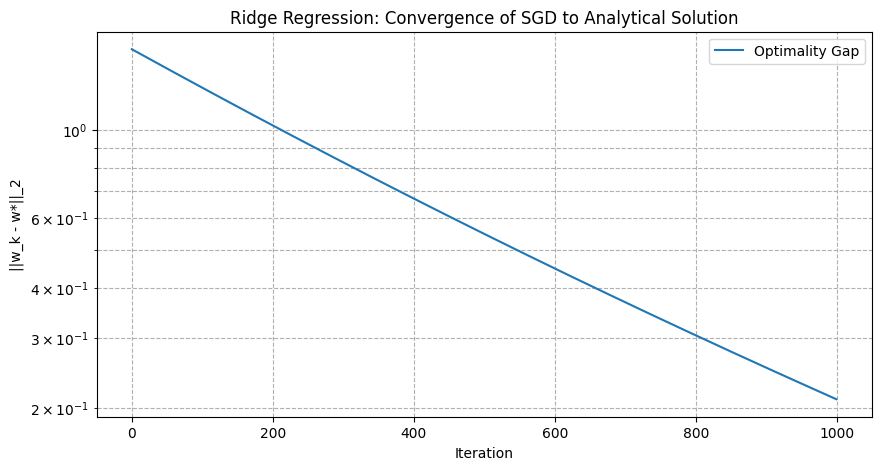

In [4]:
n = config['n_samples']
d = config['n_features']
lmbda = config['lambda']
lr = config['lr']
iters = config['iterations']

w = np.zeros(d)
gaps = []

for i in range(iters):
    prediction = X @ w
    # Gradient of Objective: 1/(2n) * ||Xw - y||^2 + lambda/2 * ||w||^2
    grad = (1/n) * X.T @ (prediction - y) + lmbda * w
    w = w - lr * grad

    gap = np.linalg.norm(w - w_star)
    gaps.append(gap)

    if i % 100 == 0:
        print(f"Iteration {i}/{iters} | Gap: {gap:.2e}")

plt.figure(figsize=(10, 5))
plt.plot(gaps, label="Optimality Gap")
plt.yscale('log')
plt.title("Ridge Regression: Convergence of SGD to Analytical Solution")
plt.xlabel("Iteration")
plt.ylabel("||w_k - w*||_2")
plt.grid(True, which="both", ls="--")
plt.legend()
plt.savefig("figures/ridge_convergence.png")
plt.show()

In [5]:
final_gap = gaps[-1]
print(f"Final Optimality Gap: {final_gap:.2e}")
with open("results/ridge_results.json", "w") as f:
    json.dump({"final_optimality_gap": float(final_gap)}, f)
print("Results saved to results/ridge_results.json")

Final Optimality Gap: 2.10e-01
Results saved to results/ridge_results.json
